# My first simulation

As introduction to the `rumdpy` package let us setting up a simulation
of a Lennard-Jones FCC crystal in the constant $NVT$ ensemble.
For a short summary, see the [minimal.py](../examples/minimal.py) example script. Also, the line `sim = rp.get_default_simulation()` will create a simulation object similar to the below.

If `rumdpy` is installed correctly, the following package should be imported without any errors. It is recommended to import the package as `rp`.

In [1]:
import rumdpy as rp

We will also import NumPy for numerical calculations and Matplotlib for plotting.

In [2]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting

## Initial particle positions

We wish to set up a configuration of a FCC lattice with $8 \times 8 \times 8$ unit cells, with a density of $\rho = 0.973$. First we create an empty configuration object.

In [3]:
configuration = rp.Configuration(D=3)

Information for a few crystal unit cells are avalible with the `rumdpy` package. For example, the FCC unit cell is stored as `rp.unit_cells.FCC`.

In [4]:
rp.unit_cells.FCC

{'fractional_coordinates': [[0.0, 0.0, 0.0],
  [0.5, 0.5, 0.0],
  [0.5, 0.0, 0.5],
  [0.0, 0.5, 0.5]],
 'lattice_constants': [1.0, 1.0, 1.0]}

We use the `make_lattice` method to assign positions and a simulation box to the  configuration object.

In [5]:
# Setup configuration: FCC Lattice
configuration.make_lattice(
    unit_cell=rp.unit_cells.FCC, 
    cells=[8, 8, 8],
    rho=0.973
)

The positions can be accessed with `['r']`. All vector properties, like the positions, are NumPy arrays.

In [6]:
positions = configuration['r']
type(positions)

numpy.ndarray

To confirm that the positions are as expected, we can visualize the configuration using Matplotlib. 

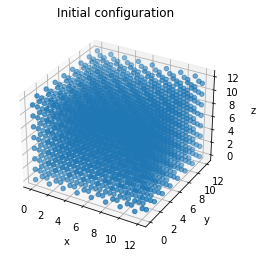

In [7]:
# Make 3D plot using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Initial configuration')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

The configuration object also contains information about the simulation box. The box lengths can be accessed with the `lengths` attribute.

In [8]:
configuration.simbox.lengths  # Box lengths

array([12.815602, 12.815602, 12.815602], dtype=float32)

## Masses and initial velocities

We set all particle masses to one.

In [9]:
configuration['m'] = 1.0  # Set all masses to 1.0

Note that `configuration['m']` refer to an NumPy array. For convenience, we above used a `float` to set all masses to the same value. This value will automatically be broadcast to all particles.

In [10]:
type(configuration['m'])  # configuration['m'] is a NumPy array

numpy.ndarray

After masses are set, we can assign random velocities corresponding to an initial kinetic temperature $T = 0.8$.

In [11]:
temperature = 0.8
configuration.randomize_velocities(temperature=temperature)

To confirm that the initial velocity distribution is as expected, we can compare it the the theoretical Maxwell-Boltzmann distribution.

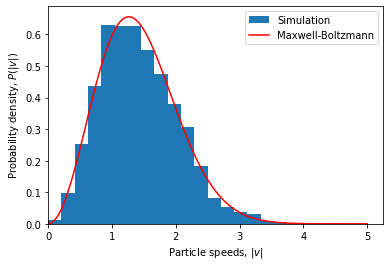

In [12]:
plt.figure()
# Histogram of particle speeds
vel = configuration['v']
speeds = np.linalg.norm(vel, axis=1)
bins = np.linspace(0, 5, 25)
plt.hist(speeds, bins=bins, density=True, label='Simulation')
# Theoretical Maxwell-Boltzmann distribution
v = np.linspace(0, 5, 100)
maxwell_boltzmann = (2*np.pi*temperature)**(-3/2)*4*np.pi*v**2*np.exp(-v**2/(2*temperature))
plt.plot(v, maxwell_boltzmann, label='Maxwell-Boltzmann', color='r')
# Plot settings
plt.xlabel(r'Particle speeds, $|v|$')
plt.ylabel(r'Probability density, $P(|v|)$')
plt.xlim(0, None)
plt.legend()
plt.show()

## Pair potential
Next, we set up the Lennard-Jones pair potential. We use the 12-6 Lennard-Jones potential

$$
  v_\infty(r) = 4\varepsilon \left[\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6}\right]
$$

(the substript refer to a "truncation" at $\infty$). Here $\sigma$ (`sigma`) is length, and $\varepsilon$ (`epsilon`) is an energy. We will use Lennard-Jones units, where $\sigma = 1$ and $\varepsilon = 1$.

Several pair potentials functions are implemented in `rumdpy`, and the above 12-6 Lennard-Jones potential is implemented as `rp.LJ_12_6_sigma_epsilon`. This is a Python function that takes distances, parameters as input and returns the potential energy, the force and the second derivative of the potential energy.

Let us confirm values are as expected in the minimum of the potential:

\begin{align}
  r_{min} &= 2^{1/6} \\
  v(r_{min}) &= -\varepsilon \\
  f(r_{min}) &= 0 \\
  \left.\frac{d^2v}{dr^2}\right|_{r_{min}} &= (624\cdot2^{-7/3}-168\cdot2^{-4/3})\frac{\varepsilon}{\sigma^2} \simeq 57.146\frac{\varepsilon}{\sigma^2}
\end{align}


In [13]:
pair_raw = rp.LJ_12_6_sigma_epsilon  # Pair potential function (raw)
r_min = 2**(1/6)
u_min, f_min, curvature_min = pair_raw(r_min, (1.0, 1.0, np.inf))
u_min, f_min, curvature_min

(-1.0, -2.1148430366511475e-15, 57.146437870855145)


To allow for a $O(N)$ algorithm for force calculations, we truncate the pair potential at radius of $r_c = 2.5\sigma$ (`cutoff`). The potential is shifted to zero at the cutoff radius, so the actual potential is

$$
  v(r) = v_\infty(r) - v_\infty(r_c)
$$

For convenience, we can use the `rp.apply_shifted_potential_cutoff` function.

In [14]:
pair_func = rp.apply_shifted_potential_cutoff(rp.LJ_12_6_sigma_epsilon)

We can now create an interaction objects using this pair potential function. 

In [15]:
sigma, epsilon, cutoff = 1.0, 1.0, 2.5
pair_pot = rp.PairPotential(pair_func, params=[sigma, epsilon, cutoff], max_num_nbs=1000)

This object contains a method for plotting the potential.

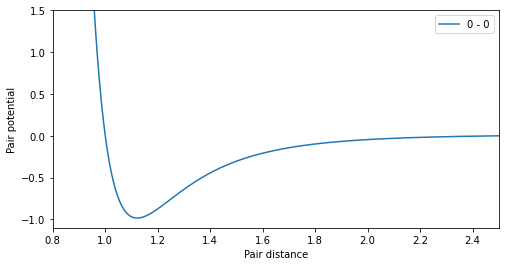

In [16]:
pair_pot.plot(xlim=(0.8, 2.5), ylim=(-1.1, 1.5))

## Integrator

Next, create an integrator object. These are avalible in the submodule `rumdpy.integrators`. Here, we chose to use and implementation of the Nosé-Hoover thermostat discretised using the Leap-Frog scheme (others are available). We set a time-step of $dt=0.005$ and a thermostat relaxation time to $\tau = 0.2$ (both in Lennard-Jones units).

In [17]:
# Setup integrator: Nosé-Hoover NVT, Leap-frog algorithm
integrator = rp.integrators.NVT(temperature=temperature, tau=0.2, dt=0.005)


## The Simulation object

We now have all the components to set up a simulation object.

* An configuration object (particle positions, velocities, masses, ...).
* An interaction object with the Lennard-Jones potential.
* An integrator object with the Nosé-Hoover thermostat.

For the simulation object we also specify that we want ten time blocks of one thousand steps. We also specify that we want to store the simulation data in memory (alternatively, data can be stored to the disk for later analysis). To avoid numerical issues, we reset the momenta every 100 steps (`steps_between_momentum_reset=100`). Here, we store the simulation data in memory (alternatively, data can be stored to the disk for later analysis).

In [18]:
# Setup Simulation. 
sim = rp.Simulation(
    configuration=configuration,
    interactions=pair_pot,
    integrator=integrator,
    steps_between_momentum_reset=100,
    num_timeblocks=10,         # The simulation is divided into 10 timeblocks
    steps_per_timeblock=1000,  #   of 1000 steps each.
    storage='memory'  # Store data in memory,
)                     #   change to storage='output.h5' for storage on disk.

## Running the simulation

Finally, we run the simulation using the `run` method. Some basic information will be displayed.

In [19]:
sim.run()  # Run simulation

time= 0.000     u= -6.179    w= 1.306     lap= 1039.006  m= 1.000     k= 1.185     fsq= 806.063   
time= 5.000     u= -6.123    w= 1.624     lap= 1065.904  m= 1.000     k= 1.198     fsq= 861.509   
time= 10.000    u= -6.184    w= 1.259     lap= 1034.928  m= 1.000     k= 1.233     fsq= 781.863   
time= 15.000    u= -6.171    w= 1.320     lap= 1040.390  m= 1.000     k= 1.188     fsq= 795.719   
time= 20.000    u= -6.124    w= 1.594     lap= 1064.078  m= 1.000     k= 1.216     fsq= 875.535   
time= 25.000    u= -6.120    w= 1.634     lap= 1066.560  m= 1.000     k= 1.177     fsq= 837.843   
time= 30.000    u= -6.166    w= 1.368     lap= 1044.062  m= 1.000     k= 1.199     fsq= 791.670   
time= 35.000    u= -6.180    w= 1.301     lap= 1038.250  m= 1.000     k= 1.188     fsq= 802.213   
time= 40.000    u= -6.130    w= 1.564     lap= 1061.382  m= 1.000     k= 1.173     fsq= 871.498   
time= 45.000    u= -6.160    w= 1.408     lap= 1047.476  m= 1.000     k= 1.169     fsq= 809.914   
Particles 

The sim methods prints some basic information after each timeblock and summary.
The output line `Extra time 1.st block ...` indicate that the first timeblock took significant longer than the remaining timeblocks.
This is due to the just in time (JIT) compilation of the Python code to run effectively on GPU's.

## Analysis

We can now analyze the simulation data. Below we extract some thermodynamic quantities stored in the simulation object (more are stored).

In [20]:
# Extract potential energy, virial and kinetic energy
U, W, K = rp.extract_scalars(sim.output, ['U', 'W', 'K'])
type(U)

numpy.ndarray

The variables `U`, `W` and `K` are NumPy arrays with the potential energy, virial and kinetic energy, respectively, for selected timesteps. The number of stored timestep can be found with `len(U)`.

In [21]:
len(U)

620

The steps between each output can be found with `sim.output_calculator.steps_between_output`.

In [22]:
sim.output_calculator.steps_between_output

16

Below we compute the times related to when the scalar quantities were stored (in Lennard-Jones units).

In [23]:
dt = sim.integrator.dt  # Time step
time = np.arange(len(U)) * dt * sim.output_calculator.steps_between_output  # Time array

We can use Matplotlib to plot the potential energy per particle as a function of time. We use `sim.configuration.N` to get the number of particles.

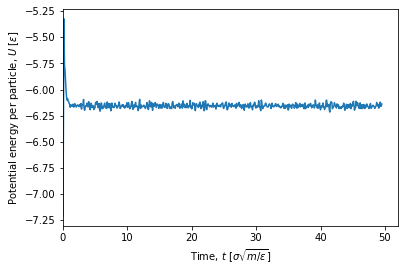

In [24]:
N = sim.configuration.N  # Number of particles

plt.figure()
plt.plot(time, U/N)
plt.xlabel(r'Time, $t$ [$\sigma\sqrt{m/\varepsilon}$]')  # Time in LJ units
plt.ylabel(r'Potential energy per particle, $U$ [$\varepsilon$]')  # Energy in LJ units
plt.xlim(0, None)
plt.show()

The first part of the simulation show large fluctuations in the potential energy since the system is not yet equilibrated (it was setup in a perfect crystal). Since we are not interested in the equilibration phase, we can discard the fir st timeblock by using the `first_block=1` argument in the `extract_scalars` function. We then need to recalculate the time array.

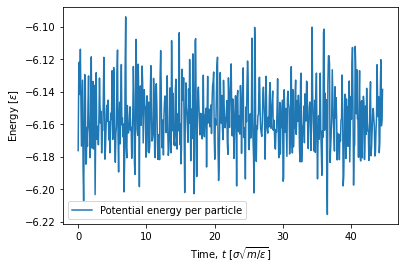

In [25]:
U, W, K = rp.extract_scalars(sim.output, ['U', 'W', 'K'], first_block=1)
time = np.arange(len(U)) * dt * sim.output_calculator.steps_between_output

plt.figure()
plt.plot(time, U/N, label='Potential energy per particle')
plt.xlabel(r'Time, $t$ [$\sigma\sqrt{m/\varepsilon}$]')  # Time in LJ units
plt.ylabel(r'Energy [$\varepsilon$]')  # Energy in LJ units
plt.legend()
plt.show()

After we have ensured that we have an equilibrium simulation, the expectation value of the potential energy per particle can be found with the `np.mean` NumPy function.

In [26]:
np.mean(U/N)

-6.15574

In an $NVT$ simulation the pressure is often an important quantity, but is not stored in the simulation data directly. The pressure can be calculated from the virial, $W$. Recall,

$$
  pV = Nk_BT + W
$$

where $p$ is the pressure, $V$ is the volume, $N$ is the number of particles, $k$ is the Boltzmann constant and $T$ is the temperature. The volume can be calculated from the box lengths. In Lennard-Jones units boltzmann constant is $k_B = 1$. Below we use this to calculate the pressure.

In [27]:
V = sim.configuration.get_volume()  # Volume
dof = 3*N - 3  # Degrees of freedom
T_kin = 2*K/dof  # Kinetic temperature
p = (N*T_kin + W)/V  # Pressure
np.mean(p)  # Mean pressure

2.1694074

## Concluding remarks
Congratulations! You have now setup and executed your first simulation with `rumdpy`. You are now ready to continue with more advanced simulations and analysis. For this, we recommend to look at the other examples.